In [1]:
import pandas as pd
import scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import RegularGridInterpolator
from scipy import integrate
import matplotlib as mpl
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import numpy as np
from numerical_tools import *
from gray_profile import *
from interior_structure import *
import random
from scipy import optimize

gamma = 7/5
G = 6.6743e-11
R_J = 69911000
M_E = 5.972*1e24
R_E = 6371000
M_J = 1.898*1e27
M_planet = 0.0519*M_J
M_planet = M_J
mu = 0.0023
R = 8.314

Radius 0.64243 Jupiter, erreur 5.50871e-01
Radius 1.19368 Jupiter, erreur 8.58076e-01
Radius 0.86803 Jupiter, erreur 2.72814e-01
Radius 1.01767 Jupiter, erreur 1.72385e-01
Radius 0.97126 Jupiter, erreur 4.56005e-02
Radius 0.98366 Jupiter, erreur 1.27653e-02
Radius 0.98111 Jupiter, erreur 2.59132e-03
Radius 0.98163 Jupiter, erreur 5.34344e-04
Radius 0.98153 Jupiter, erreur 1.08401e-04
Radius 0.98155 Jupiter, erreur 2.11689e-05
Radius 0.98154 Jupiter, erreur 4.13288e-06
Final radius 0.98 Jupter


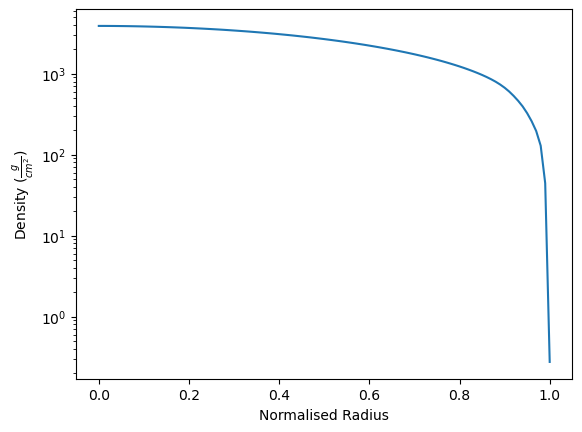

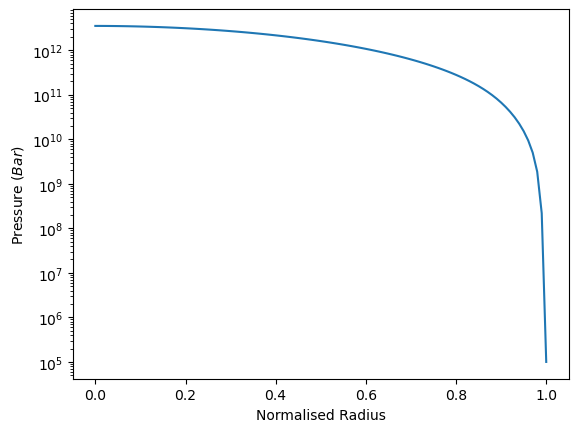

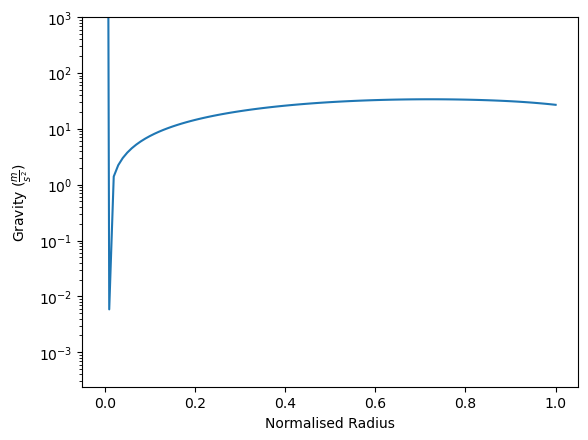

In [2]:
M_planet = M_J
P_top = 1
T_top = 100
y = 0.245

radius,pressure,rho,gravity,temperature = interior_structure(M_planet,P_top,T_top,y)

plt.figure()
plt.plot(np.array(radius)/radius[0],rho)
plt.ylabel(r'Density ($\frac{g}{cm^2}$)')
plt.xlabel(r'Normalised Radius')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(np.array(radius)/radius[0],np.array(pressure))
plt.yscale('log')
plt.ylabel(r'Pressure ($Bar$)')
plt.xlabel(r'Normalised Radius')
plt.show()

plt.figure()
plt.plot(np.array(radius)/radius[0],gravity)
plt.yscale('log')
plt.ylabel(r'Gravity ($\frac{m}{s^2}$)')
plt.xlabel(r'Normalised Radius')
plt.ylim([0,1e3])
plt.show()


Radius 1.28159 Jupiter, erreur 1.04029e-01
Radius 1.30261 Jupiter, erreur 1.64036e-02
Radius 1.30200 Jupiter, erreur 4.71774e-04
Radius 1.30201 Jupiter, erreur 9.18157e-06
Final radius 1.30 Jupter


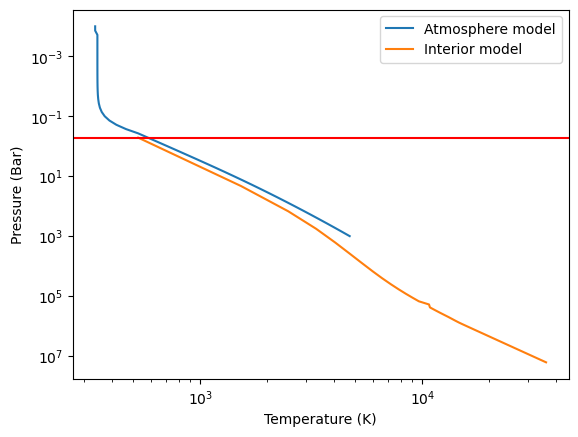

Radius 1.24578 Jupiter, erreur 1.29065e-01
Radius 1.27861 Jupiter, erreur 2.63577e-02
Radius 1.27722 Jupiter, erreur 1.08716e-03
Radius 1.27725 Jupiter, erreur 2.40907e-05
Radius 1.27725 Jupiter, erreur 4.33915e-07
Final radius 1.28 Jupter
Radius erreur -1.90038e-02


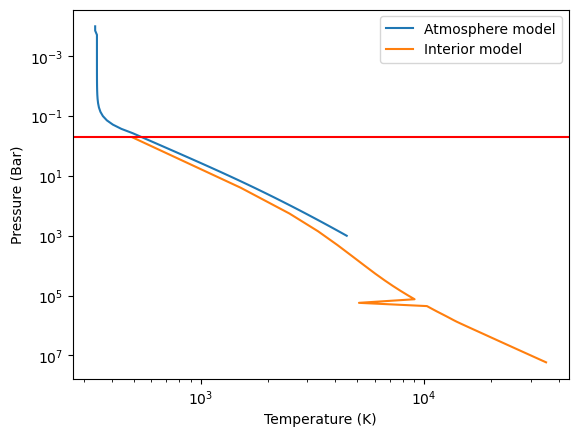

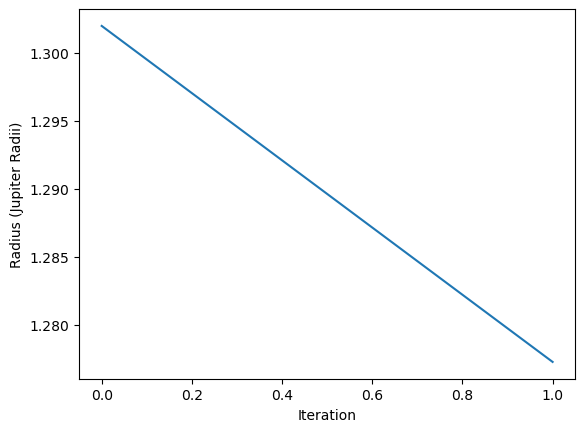

In [5]:
M_planet = M_J
y = 0.246

P = np.logspace(1,8,50)
T_eff = 400
met = 1
g_guess = 12
radius_evol = []
flag_stop = False
tolerance = 1e-3

while not flag_stop :
    df = T_profile(P,T_eff,met,g_guess,species=['H2','He'],mass_fractions=[1-y,y]).iloc[0]
    radius,pressure,rho,gravity,temperature = interior_structure(M_planet,df['P_link']*1e-5,df['T_at_P'],y)
    g_guess = gravity[0]
    radius_evol.append(radius[0])
    
    if (len(radius_evol)>1) :
        erreur = ((radius_evol[-1]-radius_evol[-2])/radius_evol[-2])
        print('Radius erreur {:.5e}'.format(erreur))
        if erreur < tolerance :
            flag_stop = True
    
    plt.figure()
    plt.plot(df['temperature'],df['pressure']*1e-5,label='Atmosphere model')
    plt.plot(temperature,np.array(pressure)*1e-5,label='Interior model')
    plt.axhline(y = df['P_link']*1e-5, color = 'r', linestyle = '-')
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (Bar)')
    plt.xlabel('Temperature (K)')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

plt.figure()
plt.plot(np.array(radius_evol)/R_J)
plt.ylabel('Radius (Jupiter Radii)')
plt.xlabel('Iteration')
plt.show()

In [144]:

def convert_thermo_format(df) :
    df_new = pd.DataFrame()    

    all_data = []
    for row in range(0,len(df)) :
        all_data += list(df.iloc[row])

    N_rho = int(all_data[0])
    N_T = int(all_data[1])

    density = []
    for jj in range(2, N_rho+2) :
        density.append(all_data[jj])

    temperature = []
    for ii in range(N_rho+2, N_rho+N_T+2) :
        temperature.append(all_data[ii])

    pressure = []
    T_temp = []
    density_temp = []
    for kk in range(0,len(temperature)):
        start_pressure = N_rho+N_T+2+(kk)*N_rho
        end_pressure = N_rho+N_T+2+(kk+1)*N_rho
        idx_in_density = 0
        for ii in range(start_pressure, end_pressure) :
            pressure.append(all_data[ii])
            T_temp.append(temperature[kk])
            density_temp.append(density[idx_in_density])
            idx_in_density += 1

    energy = []
    T_temp = []
    density_temp = []
    for kk in range(0,len(temperature)):
        start_energy = end_pressure + (kk)*N_rho
        end_energy = end_pressure + (kk+1)*N_rho
        idx_in_density = 0
        for ii in range(start_energy, end_energy) :
            energy.append(all_data[ii])
            T_temp.append(temperature[kk])
            density_temp.append(density[idx_in_density])
            idx_in_density += 1       

    entropy = []
    T_temp = []
    density_temp = []
    for kk in range(0,len(temperature)):
        start_entropy = end_energy + (kk)*N_rho
        end_entropy = end_energy + (kk+1)*N_rho
        idx_in_density = 0
        for ii in range(start_entropy, end_entropy) :
            if ii < len(all_data) :
                entropy.append(all_data[ii])
            else :
                entropy.append(np.nan)
            T_temp.append(temperature[kk])
            density_temp.append(density[idx_in_density])
            idx_in_density += 1   

    df_new['rho'] = density_temp
    df_new['T'] = T_temp
    df_new['P'] = np.array(pressure)*1e9/1e5
    df_new['E'] = energy
    df_new['S'] = np.array(entropy)*1e-7*1e3
    
    return df_new

def rho_PT(data,P,T) :
    def to_solve (rho,data,P,T) :
        return bilinear_interp(data[['T','rho','P']],T,rho) - P
    
    args = (data,P,T)
    sol = optimize.root(to_solve, 1e-2, jac=False, method='hybr',args=args)
    return float(sol.x)

def S_rhoT (data,rho,T) :
    return bilinear_interp(data[['T','rho','S']],T,rho)

def T_PS (data,P,S) :
    
    rho_PT(data,P,T)
    def to_solve (T,data,P,S) :
        rho = rho_PT(data,P,T)
        return bilinear_interp(data[['T','rho','S']],T,rho) - S
    
    args = (data,P,S)
    sol = optimize.root(to_solve, 1000, jac=False, method='hybr',args=args)
    
    return float(sol.x)

def S_mix(H, He, P, T, y) :
    x_h = (4-4*y)/(4-3*y)
    x_he = y/(4-3*y)
    Smix = -(x_h*np.log(x_h) + x_he*np.log(x_he))
    k_B_ev = 8.617 * 1e-5

    return S_rhoT(H,rho_PT(H,P,T),T) * x_h + S_rhoT(He,rho_PT(He,P,T),T) * x_he + Smix*k_B_ev

def T_PS_mix (H, He, P, y, S) :
    def to_solve(T, H, He, S, y, P) :
        return S_mix(H, He, P, T, y) - S
    
    args = (H, He, S, y, P)
    sol = optimize.root(to_solve, 1000, jac=False, method='hybr',args=args)
    
    return float(sol.x)

# ------------ #

def S_PT_PTformat (data,P,T) :
    return bilinear_interp(data[['P','T','S']],P,T)

def S_PT_mix_PTformat(H, He, P, T, y) :
    Kb = 1.380649*1e-23
    k_B_ev = 8.617 * 1e-5
    m_h = 1.66053906660*1e-27
    
    x_h = (4-4*y)/(4-3*y)
    x_he = y/(4-3*y)
    A_mean = x_h * 1 + x_he * 4
    Smix = -Kb*(x_h*np.log(x_h) + x_he*np.log(x_he))/(A_mean*m_h)
    
    return S_PT(H,P,T) * (1-y) + S_PT(He,P,T) * y + Smix

def T_PS_mix_PTformat (H, He, P, y, S) :
    def to_solve(T, H, He, S, y, P) :
        return S_PT_mix_PTformat(H, He, P, T, y) - S
    
    args = (H, He, S, y, P)
    sol = optimize.root(to_solve, 1000, jac=False, method='hybr',args=args)
    
    return float(sol.x)

def T_PS_PTformat (H_He, P, S) :
    def to_solve(T, H_He, S, P) :
        return S_PT_PTformat(H_He, P, T) - S
    
    args = (H_He, S, P)
    sol = optimize.root(to_solve, 1000, jac=False, method='hybr',args=args)
    
    return float(sol.x)
    

In [145]:
P = 1
T = 1000
y = 0.292
S_PT_mix_PTformat(H, He, P, T, y)

2016.2869959026675

In [146]:
P = 1
T = 1000
y = 0.292

H, He , H_He = load_thermo_tables () 


P_isen_PTformat = np.logspace(0,9,30)
S = S_PT_PTformat (H_He,P,T)
isen_values_direct = []
i = 0
for Pi in P_isen_PTformat :
    print('% completed {:.2f}%'.format(100*i/len(P_isen_PTformat)))
    i += 1
    try :
        isen_values_direct.append(T_PS_PTformat (H_He, Pi, S))
    except :
        isen_values_direct.append(np.nan)
        

S = S_PT_mix_PTformat(H, He, P, T, y)
isen_values_mix = []
i = 0
for Pi in P_isen_PTformat :
    print('% completed {:.2f}%'.format(100*i/len(P_isen_PTformat)))
    i += 1
    try :
        isen_values_mix.append(T_PS_mix_PTformat (H, He, Pi, y, S))
    except :
        isen_values_mix.append(np.nan)

names = ['R','rho','T','P','e','k','h','S0','S2','S4','S6','S0p','S2p','S4p','S6p']
file = '../exoris/bin/model.dat'
model = pd.read_csv(file,sep='\s+',header=1, index_col=False, names=names)


% completed 0.00%
% completed 3.33%
% completed 6.67%
% completed 10.00%
% completed 13.33%
% completed 16.67%
% completed 20.00%
% completed 23.33%
% completed 26.67%
% completed 30.00%
% completed 33.33%
% completed 36.67%
% completed 40.00%
% completed 43.33%
% completed 46.67%
% completed 50.00%
% completed 53.33%
% completed 56.67%
% completed 60.00%
% completed 63.33%
% completed 66.67%
% completed 70.00%
% completed 73.33%
% completed 76.67%
% completed 80.00%
% completed 83.33%
% completed 86.67%
% completed 90.00%
% completed 93.33%
% completed 96.67%
% completed 0.00%
% completed 3.33%
% completed 6.67%
% completed 10.00%
% completed 13.33%
% completed 16.67%
% completed 20.00%
% completed 23.33%
% completed 26.67%
% completed 30.00%
% completed 33.33%
% completed 36.67%
% completed 40.00%
% completed 43.33%
% completed 46.67%
% completed 50.00%
% completed 53.33%
% completed 56.67%
% completed 60.00%
% completed 63.33%
% completed 66.67%
% completed 70.00%
% completed 73.33%

In [111]:
P = 1
T = 1000
y = 0.292

names = ['1','2','3','4','5']
file = '../exoris/Src/eos/kerley_h/H-SESAME.dat'
H = pd.read_csv(file,sep='\s+',header=6, index_col=False, names=names).dropna()

names = ['1','2','3','4','5']
file = '../exoris/Src/eos/kerley_he/He_abinitio_FS.dat'
He = pd.read_csv(file,sep='\s+',header=6, index_col=False, names=names).dropna()

H = convert_thermo_format(H)
He = convert_thermo_format(He)

S = S_mix(H, He, P, T, y)

P_isen = np.logspace(0,9,20)

T_isen = []
i = 0
for P in P_isen :
    print('% completed {:.2f}%'.format(100*i/len(P_isen)))
    i += 1
    try :
        T_isen.append(T_PS_mix (H, He, P, y, S))
    except :
        T_isen.append(np.nan)

% completed 0.00%
% completed 5.00%
% completed 10.00%
% completed 15.00%
% completed 20.00%
% completed 25.00%
% completed 30.00%
% completed 35.00%
% completed 40.00%
% completed 45.00%
% completed 50.00%
% completed 55.00%
% completed 60.00%
% completed 65.00%
% completed 70.00%
% completed 75.00%
% completed 80.00%
% completed 85.00%
% completed 90.00%
% completed 95.00%


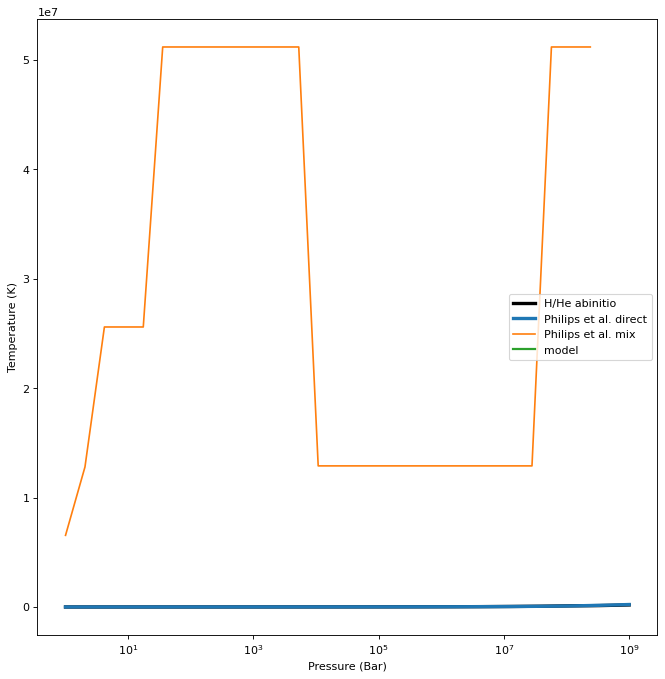

In [141]:
plt.figure(figsize=(10, 10), dpi=80)

plt.plot(P_isen,T_isen,'k',label='H/He abinitio',linewidth=3)

plt.plot(P_isen_PTformat,isen_values_direct,label='Philips et al. direct',linewidth=3)

plt.plot(P_isen_PTformat,isen_values_mix,label='Philips et al. mix')

plt.plot(model['P'],model['T'],linewidth=2,label='model')

plt.xscale('log')
#plt.yscale('log')
plt.legend()

#plt.xlim([1,1e9])
#plt.ylim([1000,90000])
plt.ylabel('Temperature (K)')
plt.xlabel('Pressure (Bar)')

plt.show()

In [133]:
file = '../exoris/bin/fort.1'
names = ['S','P','T','rho']
model = pd.read_csv(file,sep='\s+',header=0, index_col=False, names=names)

In [641]:
def thermo_mix_at_y(y) :
    # We suppose that the hydrogen and helium dataframes are of the shape (T,P) -> (rho,S) and that they hare given on the same (T,P grid)
    
    H, He = load_thermo_tables () # Load hydrogen and helium thermodynamic tables
    data = H # Set a new DataFrame from the prexisting Hydrogen DataFrame
    data['S'] = (1-y)*H['S']+y*He['S'] # Set a new DataFrame from the prexisting Hydrogen DataFrame
    data['rho'] = ((1-y)/H['rho']+y/He['rho'])**(-1)
    return data

In [642]:
def load_thermo_tables () :
    # Load hydrogen thermodynamic table and define columns (P,T,rho,S) in (bar,K,g/cc,MJ/kg/K)
    names = ['log T [K]','log P [GPa]','log rho [g/cc]','log U [MJ/kg]','log S [MJ/kg/K]','dlrho/dlT_P','dlrho/dlP_T','dlS/dlT_P','dlS/dlP_T','grad_ad']
    H = pd.read_csv('./DirTABLES-EOS2019/TABLE_H_TP_v1',sep='\s+',header=1, index_col=False, names=names)
    H = H.apply(pd.to_numeric, errors='coerce').dropna()
    H['P'] = (1e9/1e5)*10**H['log P [GPa]']
    H['T'] = 10**H['log T [K]']
    H['rho'] = 10**H['log rho [g/cc]']
    H['S'] = 10**H['log S [MJ/kg/K]']
                             
    # Load helium thermodynamic table and define columns (P,T,rho,S) in (bar,K,g/cc,MJ/kg/K)          
    He = pd.read_csv('./DirTABLES-EOS2019/TABLE_HE_TP_v1',sep='\s+',header=1, index_col=False, names=names)
    He = He.apply(pd.to_numeric, errors='coerce').dropna()
    He['P'] = (1e9/1e5)*10**He['log P [GPa]']
    He['T'] = 10**He['log T [K]']
    He['rho'] = 10**He['log rho [g/cc]']
    He['S'] = 10**He['log S [MJ/kg/K]']
    
    # Load hydrogen/helium thermodynamic table at 0.2919 mass fraction and define columns (P,T,rho,S) in (bar,K,g/cc,MJ/kg/K)     
    # Table not used
    H_He = pd.read_csv('/Users/cwilkinson/Downloads/DirEOS2021/TABLEEOS_2021_TP_Y0292_v1',sep='\s+',header=1, index_col=False, names=names)
    H_He = H_He.apply(pd.to_numeric, errors='coerce').dropna()
    H_He['P'] = (1e9/1e5)*10**H_He['log P [GPa]']
    H_He['T'] = 10**H_He['log T [K]']
    H_He['rho'] = 10**H_He['log rho [g/cc]']
    H_He['S'] = 10**H_He['log S [MJ/kg/K]']

    return H, He

In [105]:
def load_thermo_tables () :
    # Load hydrogen thermodynamic table and define columns (P,T,rho,S) in (bar,K,g/cc,MJ/kg/K)
    names = ['log T [K]','log P [GPa]','log rho [g/cc]','log U [MJ/kg]','log S [MJ/kg/K]','dlrho/dlT_P','dlrho/dlP_T','dlS/dlT_P','dlS/dlP_T','grad_ad']
    H = pd.read_csv('../data/DirEOS2021/TABLE_H_TP_v1',sep='\s+',header=1, index_col=False, names=names)
    H = H.apply(pd.to_numeric, errors='coerce').dropna()
    H['P'] = (1e9/1e5)*10**H['log P [GPa]']
    H['T'] = 10**H['log T [K]']
    H['rho'] = 10**H['log rho [g/cc]']
    H['S'] = 10**H['log S [MJ/kg/K]']
                             
    # Load helium thermodynamic table and define columns (P,T,rho,S) in (bar,K,g/cc,MJ/kg/K)          
    He = pd.read_csv('../data/DirEOS2021/TABLE_HE_TP_v1',sep='\s+',header=1, index_col=False, names=names)
    He = He.apply(pd.to_numeric, errors='coerce').dropna()
    He['P'] = (1e9/1e5)*10**He['log P [GPa]']
    He['T'] = 10**He['log T [K]']
    He['rho'] = 10**He['log rho [g/cc]']
    He['S'] = 10**He['log S [MJ/kg/K]']
    
    # Load hydrogen/helium thermodynamic table at 0.2919 mass fraction and define columns (P,T,rho,S) in (bar,K,g/cc,MJ/kg/K)     
    # Table not used
    H_He = pd.read_csv('../data/DirEOS2021/TABLEEOS_2021_TP_Y0292_v1',sep='\s+',header=1, index_col=False, names=names)
    H_He = H_He.apply(pd.to_numeric, errors='coerce').dropna()
    H_He['P'] = (1e9/1e5)*10**H_He['log P [GPa]']
    H_He['T'] = 10**H_He['log T [K]']
    H_He['rho'] = 10**H_He['log rho [g/cc]']
    H_He['S'] = 10**H_He['log S [MJ/kg/K]']

    return H, He, H_He

In [103]:
pwd

'/Users/cwilkinson/Documents/Documents - maintenance’s MacBook Pro (2)/PhD/Codes/toy_model'